<img src="https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Segmentation.png" width="400"/>

# Customer Segmentation: Estimate Individualized Responses to Incentives

Nowadays, business decision makers rely on estimating the causal effect of interventions to answer what-if questions about shifts in strategy, such as promoting specific product with discount, adding new features to a website or increasing investment from a sales team. However, rather than learning whether to take action for a specific intervention for all users, people are increasingly interested in understanding the different responses from different users to the two alternatives. Identifying the characteristics of users having the strongest response for the intervention could help make rules to segment the future users into different groups. This can help optimize the policy to use the least resources and get the most profit.

In this case study, we will use a personalized pricing example to explain how the [EconML](https://aka.ms/econml) and [DoWhy](https://github.com/py-why/dowhy) libraries could fit into this problem and provide robust and reliable causal solutions.

### Summary

1. [Background](#background)
2. [Data](#data)
3. [Create Causal Model and Identify Causal Effect with DoWhy](#identify)
4. [Get Causal Effects with EconML](#estimate)
5. [Test Estimate Robustness with DoWhy](#robustness)
    1. [Add Random Common Cause](#random-common-cause)
    2. [Add Unobserved Common Cause](#unobserved-common-cause)
    3. [Replace Treatment with a Random (Placebo) Variable](#placebo-variable)
    4. [Remove a Random Subset of the Data](#subset)
6. [Understand Treatment Effects with EconML](#interpret)
7. [Make Policy Decisions with EconML](#policy)
8. [Conclusions](#conclusion)




# Background <a id="background"></a>

<img src="https://cdn.pixabay.com/photo/2018/08/16/11/59/radio-3610287_960_720.png" width="400" />

The global online media market is growing fast over the years. Media companies are always interested in attracting more users into the market and encouraging them to buy more songs or become members. In this example, we'll consider a scenario where one experiment a media company is running is to give small discount (10%, 20% or 0) to their current users based on their income level in order to boost the likelihood of their purchase. The goal is to understand the **heterogeneous price elasticity of demand** for people with different income level, learning which users would respond most strongly to a small discount. Furthermore, their end goal is to make sure that despite decreasing the price for some consumers, the demand is raised enough to boost the overall revenue.

The EconML and DoWhy libraries complement each other in implementing this solution. On one hand, the DoWhy library can help [build a causal model, indentify the causal effect](#identify) and [test causal assumptions](#robustness). On the other hand, EconML’s `DML` based estimators can be used to take the discount variation in existing data, along with a rich set of user features, to [estimate heterogeneous price sensitivities](#estimate) that vary with multiple customer features. Then, the `SingleTreeCateInterpreter` provides a [presentation-ready summary](#interpret) of the key features that explain the biggest differences in responsiveness to a discount, and the `SingleTreePolicyInterpreter` recommends a [policy](#policy) on who should receive a discount in order to increase revenue (not only demand), which could help the company to set an optimal price for those users in the future.

In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline

# Data <a id="data"></a>


The dataset* has ~10,000 observations and includes 9 continuous and categorical variables that represent user's characteristics and online behaviour history such as age, log income, previous purchase, previous online time per week, etc. 

We define the following variables:

Feature Name|Type|Details 
:--- |:---|:--- 
**account_age** |W| user's account age
**age** |W|user's age
**avg_hours** |W| the average hours user was online per week in the past
**days_visited** |W| the average number of days user visited the website per week in the past
**friend_count** |W| number of friends user connected in the account 
**has_membership** |W| whether the user had membership
**is_US** |W| whether the user accesses the website from the US 
**songs_purchased** |W| the average songs user purchased per week in the past
**income** |X| user's income
**price** |T| the price user was exposed during the discount season (baseline price * small discount)
**demand** |Y| songs user purchased during the discount season

**To protect the privacy of the company, we use the simulated data as an example here. The data is synthetically generated and the feature distributions don't correspond to real distributions. However, the feature names have preserved their names and meaning.*


The treatment and outcome are generated using the following functions:
$$
T = 
\begin{cases}
  1 & \text{with } p=0.2,  \\
  0.9 & \text{with }p=0.3, & \text{if income}<1 \\
  0.8 & \text{with }p=0.5, \\
  \\
    1 & \text{with }p=0.7, \\
  0.9 & \text{with }p=0.2, & \text{if income}\ge1 \\
  0.8 & \text{with }p=0.1, \\
\end{cases}
$$


\begin{align}
\gamma(X) & = -3 - 14 \cdot \{\text{income}<1\} \\
\beta(X,W) & = 20 + 0.5 \cdot \text{avg_hours} + 5 \cdot \{\text{days_visited}>4\} \\
Y &= \gamma(X) \cdot T + \beta(X,W)
\end{align}



In [2]:
# Import the sample pricing data
# Nhập dữ liệu mẫu

file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/Pricing/pricing_sample.csv"
train_data = pd.read_csv(file_url)


In [3]:
train_data

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,demand
0,3,53,1.834234,2,8,1,1,4.903237,0.960863,1.0,3.917117
1,5,54,7.171411,7,9,0,1,3.330161,0.732487,1.0,11.585706
2,3,33,5.351920,6,9,0,1,3.036203,1.130937,1.0,24.675960
3,2,34,6.723551,0,8,0,1,7.911926,0.929197,1.0,6.361776
4,4,30,2.448247,5,8,1,0,7.148967,0.533527,0.8,12.624123
...,...,...,...,...,...,...,...,...,...,...,...
9995,2,56,6.095439,3,10,0,0,7.406568,0.545599,0.8,9.447720
9996,3,52,7.828183,7,5,0,1,0.782374,0.944415,0.8,15.314092
9997,1,27,6.527350,6,9,0,1,10.926441,0.815953,1.0,11.263675
9998,4,49,2.803943,6,9,1,1,4.205016,0.504313,0.8,12.801971


In [4]:
# Data sample
train_data.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,demand
0,3,53,1.834234,2,8,1,1,4.903237,0.960863,1.0,3.917117
1,5,54,7.171411,7,9,0,1,3.330161,0.732487,1.0,11.585706
2,3,33,5.351920,6,9,0,1,3.036203,1.130937,1.0,24.675960
3,2,34,6.723551,0,8,0,1,7.911926,0.929197,1.0,6.361776
4,4,30,2.448247,5,8,1,0,7.148967,0.533527,0.8,12.624123


In [5]:
# Define estimator inputs
# Định nghĩa các các biến đầu vào cho ước tính 
train_data["log_demand"] = np.log(train_data["demand"])
train_data["log_price"] = np.log(train_data["price"])
#lấy giá trị của cột logarit của demand để làm biến outcome
Y = train_data["log_demand"].values
#lấy giá trị của cột logarit của price để làm biến treatment
T = train_data["log_price"].values
#lấy giá trị cột income làm biến đặc trưng 
X = train_data[["income"]].values  # features
#danh sách biến gây nhiễu 
confounder_names = ["account_age", "age", "avg_hours", "days_visited", "friends_count", "has_membership", "is_US", "songs_purchased"]
#lấy giá trị của các cột biến gẫy nhiễu làm biến gây nhiễu
W = train_data[confounder_names].values

In [6]:
# Get test data
#lấy dữ liệu kiểm tra 
# mảng gồm 100 số từ 0 đến 5 
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
#Chuyển đổi mảng 2D thành một DataFrame với tên cột là "income".
X_test_data = pd.DataFrame(X_test, columns=["income"])

In [7]:
X_test

array([[0.        ],
       [0.05050505],
       [0.1010101 ],
       [0.15151515],
       [0.2020202 ],
       [0.25252525],
       [0.3030303 ],
       [0.35353535],
       [0.4040404 ],
       [0.45454545],
       [0.50505051],
       [0.55555556],
       [0.60606061],
       [0.65656566],
       [0.70707071],
       [0.75757576],
       [0.80808081],
       [0.85858586],
       [0.90909091],
       [0.95959596],
       [1.01010101],
       [1.06060606],
       [1.11111111],
       [1.16161616],
       [1.21212121],
       [1.26262626],
       [1.31313131],
       [1.36363636],
       [1.41414141],
       [1.46464646],
       [1.51515152],
       [1.56565657],
       [1.61616162],
       [1.66666667],
       [1.71717172],
       [1.76767677],
       [1.81818182],
       [1.86868687],
       [1.91919192],
       [1.96969697],
       [2.02020202],
       [2.07070707],
       [2.12121212],
       [2.17171717],
       [2.22222222],
       [2.27272727],
       [2.32323232],
       [2.373

Mảng 2D này có thể được sử dụng làm dữ liệu kiểm tra trong các mô hình dự đoán để xem cách mô hình dự đoán nhu cầu (demand) thay đổi theo thu nhập (income).

# Create Causal Model and Identify Causal Effect with DoWhy <a id="identify"></a>

We define the causal assumptions with DoWhy. For example, we can include features we believe as confounders and features we think will influence the heterogeneity of the effect. With these assumptions defined, DoWhy can generate a causal graph for us, and use that graph to first identify the causal effect.

-> Xác định các giả định nhân quả bằng DoWhy. DoWhy sử dụng các đặc điểm: confounders and features cho rằng ảnh hưởng đồng nhất đến effect. DoWhy tạo biểu đồ để xác định tác động nhân quả


In [8]:
# initiate an EconML cate estimator
#model_y sử dụng gradientboostingRegressor để dự đoán biến outcome
#model_t sử dụng mô hình để dự đoán biến treatment
#Bộ tạo đặc trưng từ thư viện scikit-learn. Nó tạo ra các đặc trưng mới bằng cách lấy tất cả các kết hợp đa thức bậc 2 của các biến đầu vào.
est = LinearDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor(),
              featurizer=PolynomialFeatures(degree=2, include_bias=False))

In [9]:
# fit through dowhy
#Sử dụng gói statsmodels để thực hiện suy luận thống kê
#ước lượng tác động nhân quả của giá lên nhu cầu trong bối cảnh có các biến gây nhiễu và đặc trưng khác
est_dw = est.dowhy.fit(Y, T, X=X, W=W, outcome_names=["log_demand"], treatment_names=["log_price"], feature_names=["income"],
               confounder_names=confounder_names, inference="statsmodels")

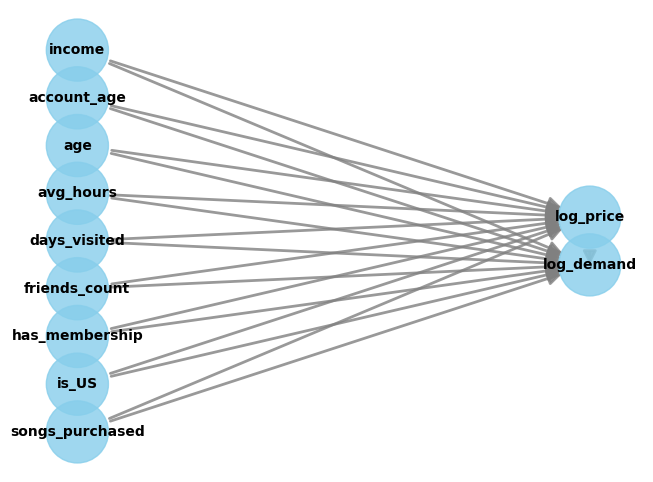

In [10]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(est_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    est_dw.view_model(layout=None) 

1. Khởi tạo một ước lượng CATE bằng LinearDML với các mô hình GradientBoostingRegressor để dự đoán biến kết quả và biến điều trị, và sử dụng PolynomialFeatures để tạo các đặc trưng bậc hai.
2. Huấn luyện mô hình này với dữ liệu đã chuẩn bị sử dụng thư viện DoWhy.
3. Trực quan hóa đồ thị nhân quả bằng cách tạo và hiển thị đồ thị.

In [11]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ↪
────────────(E[log_demand|income,days_visited,friends_count,age,account_age,is ↪
d[log_price]                                                                   ↪

↪                                              
↪ _US,songs_purchased,has_⟨membership,⟩_hours])
↪                                              
Estimand assumption 1, Unconfoundedness: If U→{log_price} and U→log_demand then P(log_demand|log_price,income,days_visited,friends_count,age,account_age,is_US,songs_purchased,has_membership,avg_hours,U) = P(log_demand|log_price,income,days_visited,friends_count,age,account_age,is_US,songs_purchased,has_membership,avg_hours)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



- loại đại lượng ước lượng là ATE
- ước lượng theo pp backdoor với giả định là không có biến gây nhiễu

# Get Causal Effects with EconML <a id="estimate"></a>

Based on the identified causal effect above, we fit the model as follows using EconML:


\begin{align}
log(Y) & = \theta(X) \cdot log(T) + f(X,W) + \epsilon \\
log(T) & = g(X,W) + \eta
\end{align}


where $\epsilon, \eta$ are uncorrelated error terms. 


The models we fit here aren't an exact match for the data generation function above, but if they are a good approximation, they will allow us to create a good discount policy.  Although the model is misspecified, we hope to see that our `DML` based estimators can still capture the right trend of $\theta(X)$ and that the recommended policy beats other baseline policies (such as always giving a discount) on revenue.  Because of the mismatch between the data generating process and the model we're fitting, there isn't a single true $\theta(X)$ (the true elasticity varies with not only X but also T and W), but given how we generate the data above, we can still calculate the range of true $\theta(X)$ to compare against.

In [12]:
# Define underlying treatment effect function given DGP
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)
# Hàm này tính toán giá trị của 𝛾(𝑋) dựa trên biến đặc trưng income.
def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)
#Hàm này tính toán giá trị của 𝛽(𝑋) dựa trên các biến đặc trưng avg_hours và days_visited
def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y
#Hàm này tính toán nhu cầu (𝑌) dựa trên các giá trị của 𝑇 (biến điều trị - giá) và các biến đặc trưng khác.

def true_te(x, n, stats):
    #sử dụng sample để lấy mẫu ngẫu nhiên từ tập train data
    if x < 1:
        subdata = train_data[train_data["income"] < 1].sample(n=n, replace=True)
    else:
        subdata = train_data[train_data["income"] >= 1].sample(n=n, replace=True)
    te_array = subdata["price"] * gamma_fn(subdata) / (subdata["demand"])
    if stats == "mean":
        return np.mean(te_array)
    elif stats == "median":
        return np.median(te_array)
    elif isinstance(stats, int):
        return np.percentile(te_array, stats)
#Hàm này tính toán tác động thực sự (true treatment effect) của giá lên nhu cầu cho một mức thu nhập cụ thể (𝑥), dựa trên dữ liệu mẫu
#x: Giá trị thu nhập để phân chia dữ liệu.
#n: Số lượng mẫu được lấy từ tập dữ liệu ban đầu.
#stats: Chỉ định loại thống kê (mean, median, hoặc một percentile cụ thể) để tính toán tác động.

In [13]:
# Get the estimate and range of true treatment effect
truth_te_estimate = np.apply_along_axis(true_te, 1, X_test, 1000, "mean")  # estimate
truth_te_upper = np.apply_along_axis(true_te, 1, X_test, 1000, 95)  # upper level
truth_te_lower = np.apply_along_axis(true_te, 1, X_test, 1000, 5)  # lower level

truth_te_estimate: Mảng chứa ước lượng trung bình của tác động điều trị thực sự cho từng giá trị thu nhập trong 𝑋test

truth_te_upper: Mảng chứa mức trên của tác động điều trị thực sự (percentile 95) cho từng giá trị thu nhập trong 𝑋test

truth_te_lower: Mảng chứa mức dưới của tác động điều trị thực sự (percentile 5) cho từng giá trị thu nhập trong 𝑋test

np.apply_along_axis(func1d, axis, arr, *args, **kwargs)

func1d: hàm 1-D được sử dụng cho mảng 2 chiều X-test

axis: 

0: lấy theo chiều dọc; 1: lấy theo chiều ngang của mảng 1 chiều

-1: chiều cuối cùng trong mảng đối với các mảng trên 2 chiều

1: lấy chiều ngang với mảng từ 2 chiều trở lên

*args, **kwargs: tham số được truyền thêm vào hàm ( ở đây là 1000 và mean )

## Parametric heterogeneity ( tham số )
First of all, we can try to learn a **linear projection of the treatment effect** assuming a polynomial form of $\theta(X)$. We use the `LinearDML` estimator. Since we don't have any priors on these models, we use a generic gradient boosting tree estimators to learn the expected price and demand from the data.

In [14]:
lineardml_estimate = est_dw.estimate_
print(lineardml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ↪
────────────(E[log_demand|income,days_visited,friends_count,age,account_age,is ↪
d[log_price]                                                                   ↪

↪                                              
↪ _US,songs_purchased,has_⟨membership,⟩_hours])
↪                                              
Estimand assumption 1, Unconfoundedness: If U→{log_price} and U→log_demand then P(log_demand|log_price,income,days_visited,friends_count,age,account_age,is_US,songs_purchased,has_membership,avg_hours,U) = P(log_demand|log_price,income,days_visited,friends_count,age,account_age,is_US,songs_purchased,has_membership,avg_hours)

## Realized estimand
b: log_demand~log_price+income+days_visited+friends_count+age+account_age+is_US+songs_purchased+has_members

Mục tiêu: Ước lượng tác động nhân quả của log_price lên log_demand sử dụng LinearDML.

Phương pháp: Sử dụng backdoor criterion và giả định không có gây nhiễu (unconfoundedness assumption).

Mean value: Giá trị trung bình của tác động điều trị ước lượng được là -0.993. Điều này có nghĩa là trung bình, một đơn vị tăng trong log_price dẫn đến giảm 0.993 đơn vị trong log_demand.

In [15]:
# Get treatment effect and its confidence interval
#tính toán hiệu ứng treatment không đồng nhất với tập kiểm tra là X_test (treatment effect) 
te_pred = est_dw.effect(X_test).flatten()
#tính toán khoảng tin cậy
te_pred_interval = est_dw.effect_interval(X_test)

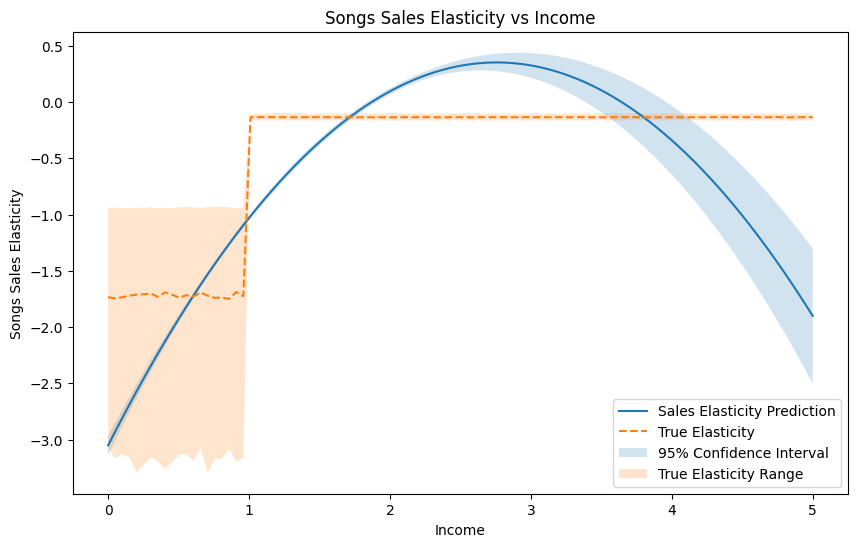

In [16]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
#độ co dãn dự đoán
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
#độ co dãn thật sự
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
#khoảng tin cậy
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0].flatten(),
    te_pred_interval[1].flatten(),
    alpha=0.2,
    label="95% Confidence Interval",
)
#khoảng co dãn thật sự
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right")

độ co giãn âm và người dân ít nhạy cảm hơn với sự thay đổi giá cả nếu họ có thu nhập cao hơn.

From the plot above, it's clear to see that the true treatment effect is a **nonlinear** function of income, with elasticity around -1.75 when income is smaller than 1 and a small negative value when income is larger than 1. The model fits a quadratic treatment effect, which is not a great fit. But it still captures the overall trend: the elasticity is negative and people are less sensitive to the price change if they have higher income.

Từ biểu đồ trên, có thể thấy rõ rằng hiệu quả can thiệp thực sự là một hàm phi tuyến tính của thu nhập, với độ co giãn khoảng -1,75 khi thu nhập nhỏ hơn 1 và giá trị âm nhỏ khi thu nhập lớn hơn 1. Mô hình phù hợp với cách xử lý bậc hai hiệu ứng này không phù hợp lắm. Nhưng nó vẫn nắm bắt được xu hướng chung: độ co giãn âm và người dân ít nhạy cảm hơn với sự thay đổi giá cả nếu họ có thu nhập cao hơn.

In [17]:
# Get the final coefficient and intercept summary
est_dw.summary(feature_names=["income"])

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
income,2.468,0.071,34.553,0.0,2.328,2.608
income^2,-0.448,0.025,-18.261,0.0,-0.496,-0.399
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-3.05,0.044,-69.327,0.0,-3.137,-2.964


`LinearDML` estimator can also return the summary of the coefficients and intercept for the final model, including point estimates, p-values and confidence intervals. From the table above, we notice that $income$ has positive effect and ${income}^2$ has negative effect, and both of them are statistically significant.

Công cụ ước tính LinearDML cũng có thể trả về bản tóm tắt các hệ số và điểm chặn cho mô hình cuối cùng, bao gồm ước tính điểm, giá trị p và khoảng tin cậy. Từ bảng trên ta nhận thấy rằng $income$  có tác dụng tích cựcvà ${income}^2$ 
 có tác động tiêu cực và cả hai đều có ý nghĩa thống kê.

## Nonparametric Heterogeneity ( phi tham số - phi tuyến tính )
Since we already know the true treatment effect function is nonlinear, let us fit another model using `CausalForestDML`, which assumes a fully **nonparametric estimation of the treatment effect**.

In [18]:
# initiate an EconML cate estimator
#sử dụng mô hình mô hình causal forest
est_nonparam = CausalForestDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor())
# fit through dowhy
est_nonparam_dw = est_nonparam.dowhy.fit(Y, T, X=X, W=W, outcome_names=["log_demand"], treatment_names=["log_price"],
                                         feature_names=["income"], confounder_names=confounder_names, inference="blb")

In [19]:
# Get treatment effect and its confidence interval
te_pred = est_nonparam_dw.effect(X_test).flatten()
te_pred_interval = est_nonparam_dw.effect_interval(X_test)

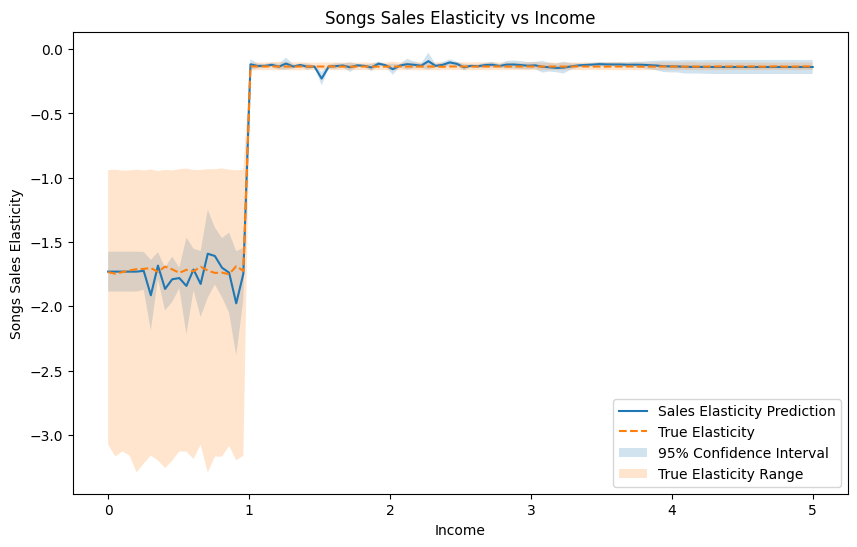

In [20]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0].flatten(),
    te_pred_interval[1].flatten(),
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right")

We notice that this model fits much better than the `LinearDML`, the 95% confidence interval correctly covers the true treatment effect estimate and captures the variation when income is around 1. Overall, the model shows that people with low income are much more sensitive to the price changes than higher income people.

Chúng tôi nhận thấy rằng mô hình này phù hợp hơn nhiều so với LinearDML, khoảng tin cậy 95% bao hàm chính xác ước tính hiệu quả điều trị thực sự và nắm bắt được sự thay đổi khi thu nhập ở khoảng 1. Nhìn chung, mô hình cho thấy những người có thu nhập thấp nhạy cảm hơn nhiều với giá thay đổi so với những người có thu nhập cao hơn.

# Test Estimate Robustness with DoWhy <a id="robustness"></a>

### Add Random Common Cause <a id="random-common-cause"></a>

How robust are our estimates to adding another confounder? We use DoWhy to test this!

In [21]:
res_random = est_nonparam_dw.refute_estimate(method_name="random_common_cause", num_simulations=5)
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.9574050881634266
New effect:-0.9559879111880495
p value:0.31134390236917714



-kiểm tra độ bền vững của ước lượng tác động điều trị (treatment effect) khi thêm một biến gây nhiễu ngẫu nhiên (random common cause). 

Refute: Add a random common cause:
Tên của phương pháp kiểm tra độ bền vững, cho biết một biến gây nhiễu ngẫu nhiên đã được thêm vào mô hình.

Estimated effect: -0.9590993329875213: Tác động điều trị ước lượng ban đầu từ mô hình là -0.959.

New effect: -0.9559298435174985: Tác động điều trị mới sau khi thêm biến gây nhiễu ngẫu nhiên là -0.956.

p value: 0.1353492332421919: Giá trị p để kiểm tra sự khác biệt giữa tác động ước lượng ban đầu và tác động mới sau khi thêm biến gây nhiễu. Giá trị p này cho biết mức độ ý nghĩa thống kê của sự khác biệt giữa hai ước lượng.

Độ bền vững của ước lượng:

Kết quả cho thấy tác động điều trị ước lượng ban đầu (-0.959) và tác động điều trị mới sau khi thêm biến gây nhiễu ngẫu nhiên (-0.956) khá gần nhau.
Sự khác biệt giữa hai ước lượng này là nhỏ, cho thấy rằng mô hình ban đầu có độ bền vững tốt với sự bổ sung của một biến gây nhiễu ngẫu nhiên.
Giá trị p (p value):

Giá trị p là 0.135, lớn hơn mức ý nghĩa thông thường (thường là 0.05). Điều này cho thấy sự khác biệt giữa hai ước lượng không có ý nghĩa thống kê.
Nói cách khác, việc thêm một biến gây nhiễu ngẫu nhiên không làm thay đổi đáng kể ước lượng tác động điều trị, cho thấy mô hình ban đầu là khá bền vững với sự hiện diện của các biến gây nhiễu.

### Add Unobserved Common Cause <a id="unobserved-common-cause"></a>

How robust are our estimates to unobserved confounders? Since we assume the model is under unconfoundedness, adding an unobserved confounder might bias the estimates. We use DoWhy to test this!

In [22]:
res_unobserved = est_nonparam_dw.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:-0.9574050881634266
New effect:-1.0112830226051355



Phương pháp để kiểm tra độ bền vững của ước lượng bằng cách thêm một biến gây nhiễu không quan sát được.

Refute: Add an Unobserved Common Cause: Tên của phương pháp kiểm tra độ bền vững, cho biết một biến gây nhiễu không quan sát được đã được thêm vào mô hình.

Estimated effect: -0.9590993329875213: Tác động điều trị ước lượng ban đầu từ mô hình là -0.959.

New effect: -1.0103946818313732: Tác động điều trị mới sau khi thêm biến gây nhiễu không quan sát được là -1.010.

Độ bền vững của ước lượng:

Kết quả cho thấy tác động điều trị ước lượng ban đầu (-0.959) và tác động điều trị mới sau khi thêm biến gây nhiễu không quan sát được (-1.010) có sự khác biệt đáng kể.
Sự khác biệt này cho thấy mô hình ban đầu nhạy cảm với sự hiện diện của các biến gây nhiễu không quan sát được, tức là ước lượng ban đầu có thể bị sai lệch khi có các biến gây nhiễu không quan sát được.
Giá trị p (p-value):

Kết quả này không cung cấp giá trị p, nhưng sự khác biệt lớn giữa hai ước lượng cho thấy rằng tác động của biến gây nhiễu không quan sát được là đáng kể.

### Replace Treatment with a Random (Placebo) Variable <a id="placebo-variable"></a>

What happens our estimates if we replace the treatment variable with noise? Ideally, the average effect would be wildly different than our original estimate. We use DoWhy to investigate!

In [23]:
res_placebo = est_nonparam_dw.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.9574050881634266
New effect:-0.004581555221039909
p value:0.34869998592122775



 Phương pháp để kiểm tra độ bền vững của ước lượng bằng cách thay thế biến điều trị bằng một biến ngẫu nhiên.
Refute: Use a Placebo Treatment: Tên của phương pháp kiểm tra độ bền vững, cho biết biến điều trị thực sự đã được thay thế bằng một biến ngẫu nhiên (placebo).

Estimated effect: -0.9590993329875213: Tác động điều trị ước lượng ban đầu từ mô hình là -0.959.

New effect: -0.007289902897140782: Tác động điều trị mới sau khi thay thế biến điều trị bằng biến ngẫu nhiên là -0.007.

p value: 0.19751083960102322: Giá trị p để kiểm tra sự khác biệt giữa tác động ước lượng ban đầu và tác động mới sau khi thay thế biến điều trị. Giá trị p này cho biết mức độ ý nghĩa thống kê của sự khác biệt giữa hai ước lượng.

Ý nghĩa của kết quả

Độ bền vững của ước lượng:
Kết quả cho thấy tác động điều trị ước lượng ban đầu (-0.959) và tác động điều trị mới sau khi thay thế biến điều trị bằng biến ngẫu nhiên (-0.007) có sự khác biệt rất lớn.
Sự khác biệt lớn này cho thấy rằng biến điều trị thực sự có tác động đáng kể đến biến kết quả, và mô hình đã phát hiện đúng tác động này.
Giá trị p (p-value):

Giá trị p là 0.198, lớn hơn mức ý nghĩa thông thường (thường là 0.05). Điều này cho thấy sự khác biệt giữa hai ước lượng không có ý nghĩa thống kê. Tuy nhiên, sự khác biệt lớn về giá trị ước lượng cho thấy rằng tác động của biến điều trị thực sự là rõ ràng.
 

### Remove a Random Subset of the Data <a id="subset"></a>

Do we recover similar estimates on subsets of the data? This speaks to the ability of our chosen estimator to generalize well. We use DoWhy to investigate this!

In [24]:
res_subset = est_nonparam_dw.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.9574050881634266
New effect:-0.9567321775826828
p value:0.4449868899566042



Phương pháp để kiểm tra độ bền vững của ước lượng bằng cách sử dụng một tập con ngẫu nhiên của dữ liệu. (80%)

Refute: Use a subset of data: Tên của phương pháp kiểm tra độ bền vững, cho biết mô hình đã sử dụng một tập con ngẫu nhiên của dữ liệu để kiểm tra độ bền vững của ước lượng.

Estimated effect: -0.9590993329875213: Tác động điều trị ước lượng ban đầu từ mô hình là -0.959.

New effect: -0.960728967372631: Tác động điều trị mới sau khi sử dụng một tập con ngẫu nhiên của dữ liệu là -0.961.

p value: 0.42889555114431355: Giá trị p để kiểm tra sự khác biệt giữa tác động ước lượng ban đầu và tác động mới sau khi sử dụng tập con ngẫu nhiên của dữ liệu. Giá trị p này cho biết mức độ ý nghĩa thống kê của sự khác biệt giữa hai ước lượng.

Ý nghĩa của kết quả
Độ bền vững của ước lượng:

Kết quả cho thấy tác động điều trị ước lượng ban đầu (-0.959) và tác động điều trị mới sau khi sử dụng một tập con ngẫu nhiên của dữ liệu (-0.961) gần như giống nhau.
Sự khác biệt giữa hai ước lượng là rất nhỏ, cho thấy mô hình có độ bền vững tốt và có khả năng tổng quát hóa trên các tập con dữ liệu khác nhau.
Giá trị p (p-value):

Giá trị p là 0.429, lớn hơn mức ý nghĩa thông thường (thường là 0.05). Điều này cho thấy sự khác biệt giữa hai ước lượng không có ý nghĩa thống kê, cho thấy rằng mô hình có thể tổng quát hóa tốt trên các tập con ngẫu nhiên của dữ liệu.

# Understand Treatment Effects with EconML <a id="interpret"></a>
EconML includes interpretability tools to better understand treatment effects. Treatment effects can be complex, but oftentimes we are interested in simple rules that can differentiate between users who respond positively, users who remain neutral and users who respond negatively to the proposed changes.

The EconML `SingleTreeCateInterpreter` provides interperetability by training a single decision tree on the treatment effects outputted by the any of the EconML estimators. In the figure below we can see in dark red users respond strongly to the discount and the in white users respond lightly to the discount.

EconML bao gồm các công cụ diễn giải để hiểu rõ hơn về hiệu quả điều trị. Hiệu quả điều trị có thể phức tạp nhưng đôi khi chúng tôi quan tâm đến các quy tắc đơn giản có thể phân biệt giữa người dùng phản hồi tích cực, người dùng giữ thái độ trung lập và người dùng phản hồi tiêu cực với những thay đổi được đề xuất.

EconML `SingleTreeCateInterpreter` cung cấp khả năng tương tác bằng cách đào tạo một cây quyết định duy nhất về các hiệu ứng xử lý do bất kỳ công cụ ước tính EconML nào đưa ra. Trong hình bên dưới, chúng ta có thể thấy người dùng màu đỏ sẫm phản ứng mạnh mẽ với việc giảm giá và người dùng màu trắng phản ứng nhẹ với việc giảm giá.

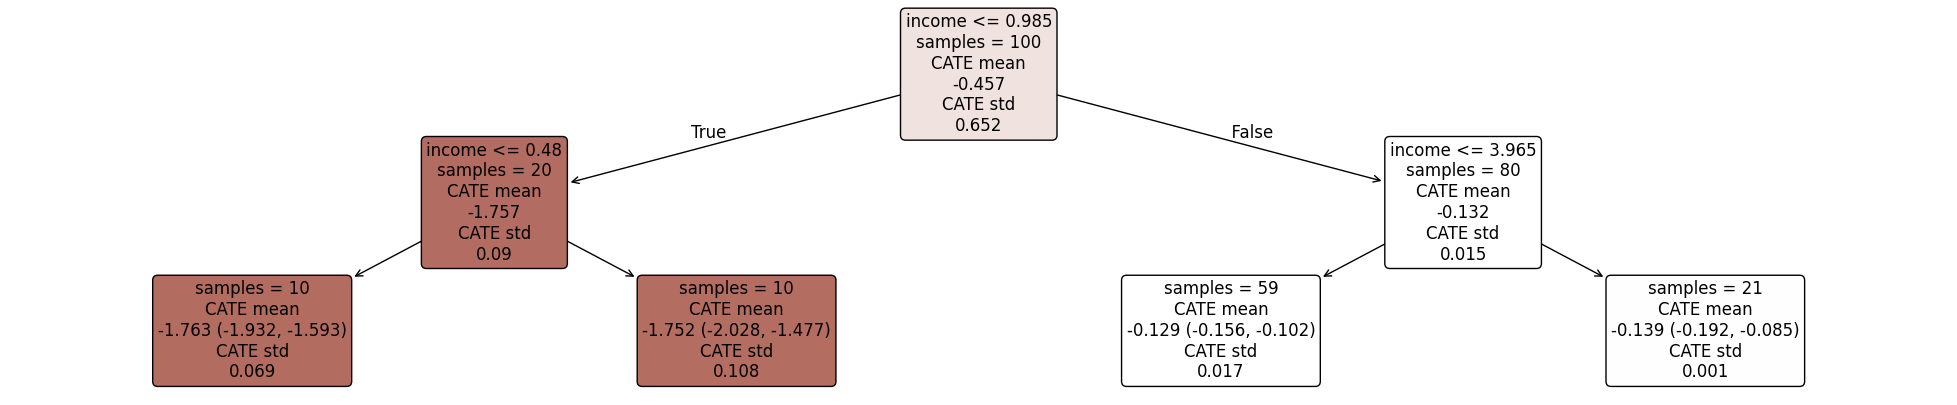

In [25]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est_nonparam_dw, X_test)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=["income"], fontsize=12)

Nhóm có thu nhập thấp:

Những người dùng có thu nhập nhỏ hơn hoặc bằng 0.985 có tác động điều trị trung bình âm mạnh hơn (-0.453). Điều này cho thấy rằng những người dùng này nhạy cảm hơn với thay đổi giá và có xu hướng giảm nhu cầu khi giá tăng.
Trong nhóm này, những người dùng có thu nhập nhỏ hơn hoặc bằng 0.48 có tác động điều trị trung bình thậm chí còn âm hơn (-1.802), cho thấy mức độ nhạy cảm cao nhất với thay đổi giá.

Nhóm có thu nhập cao:
Những người dùng có thu nhập lớn hơn 0.985 có tác động điều trị trung bình ít âm hơn (-0.116). Điều này cho thấy rằng những người dùng này ít nhạy cảm hơn với thay đổi giá so với nhóm có thu nhập thấp.
Trong nhóm này, những người dùng có thu nhập lớn hơn 3.359 có tác động điều trị trung bình gần như không âm (-0.1).

Độ lệch chuẩn:
Độ lệch chuẩn (CATE std) được bao gồm trong các nút cho thấy mức độ biến động của các ước lượng tác động điều trị. Độ lệch chuẩn thấp cho thấy ước lượng ổn định hơn trong nhóm đó.

# Make Policy Decision with EconML <a id="policy"></a>
We want to make policy decisions to maximum the **revenue** instead of the demand. In this scenario,


\begin{align}
Rev & = Y \cdot T \\
    & = \exp^{log(Y)} \cdot T\\
    & = \exp^{(\theta(X) \cdot log(T) + f(X,W) + \epsilon)} \cdot T \\
    & = \exp^{(f(X,W) + \epsilon)} \cdot T^{(\theta(X)+1)}
\end{align}


With the decrease of price, revenue will increase only if $\theta(X)+1<0$. Thus, we set `sample_treatment_cast=-1` here to learn **what kinds of customers we should give a small discount to maximum the revenue**.

Với điều kiện 𝜃(𝑋)+1<0:
Khi giá giảm, doanh thu sẽ tăng nếu θ(X)+1<0. Điều này có nghĩa là tác động điều trị có điều kiện (CATE) phải âm và đủ lớn để làm cho biểu thức  θ(X)+1 nhỏ hơn 0.

The EconML library includes policy interpretability tools such as `SingleTreePolicyInterpreter` that take in a treatment cost and the treatment effects to learn simple rules about which customers to target profitably. In the figure below we can see the model recommends to give discount for people with income less than $0.985$ and give original price for the others.

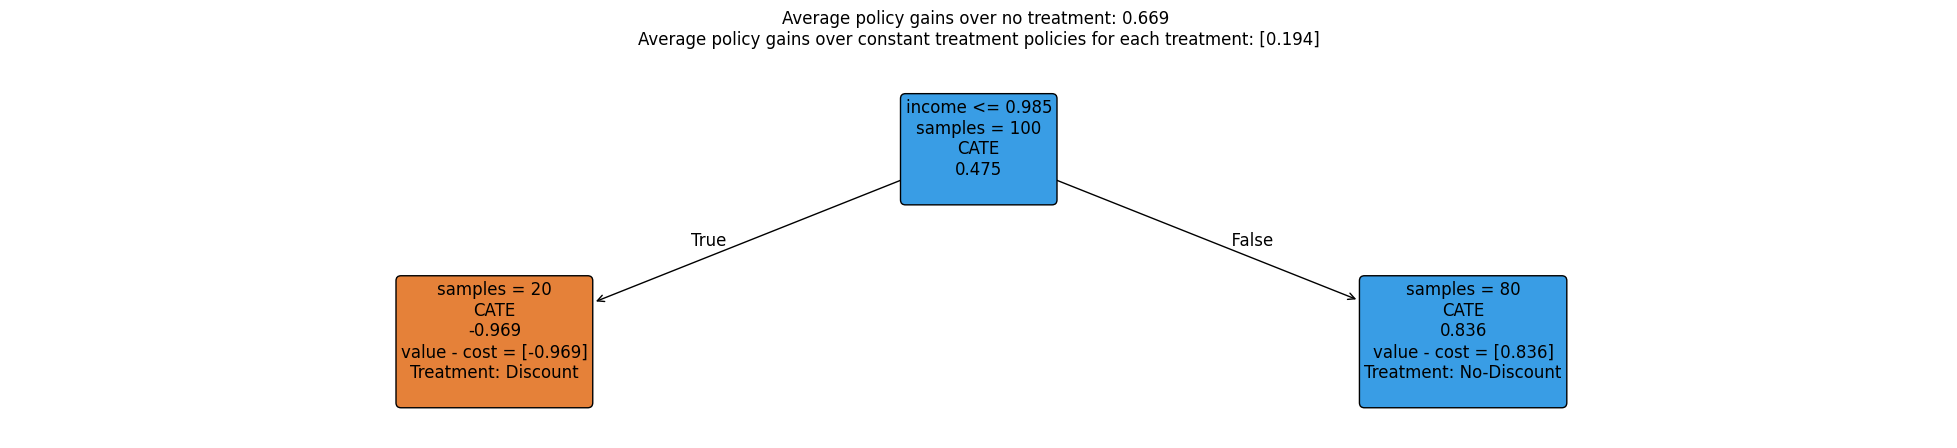

In [26]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=0.001)
intrp.interpret(est_nonparam_dw, X_test, sample_treatment_costs=-1)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=["income"], treatment_names=["Discount", "No-Discount"], fontsize=12)

sử dụng công cụ SingleTreePolicyInterpreter của EconML để đưa ra quyết định chính sách nhằm tối đa hóa doanh thu.

Nhóm có thu nhập thấp:

Những người dùng có thu nhập nhỏ hơn hoặc bằng 0.985 có tác động điều trị trung bình là 0.49.
Trong nhóm này, những người dùng có thu nhập nhỏ hơn hoặc bằng 0.985 có tác động điều trị trung bình âm mạnh hơn (-1.018). Điều này cho thấy rằng nhóm này nên được giảm giá để tối đa hóa doanh thu.

Nhóm có thu nhập cao:

Những người dùng có thu nhập lớn hơn 0.985 có tác động điều trị trung bình là 0.867.
Trong nhóm này, tác động điều trị trung bình là dương (0.867), cho thấy rằng nhóm này không nên được giảm giá để tối đa hóa doanh thu.


Now, let us compare our policy with other baseline policies! Our model says which customers to give a small discount to, and for this experiment, we will set a discount level of 10% for those users. Because the model is misspecified we would not expect good results with large discounts. Here, because we know the ground truth, we can evaluate the value of this policy.

Bây giờ, chúng ta hãy so sánh chính sách của chúng tôi với các chính sách cơ bản khác! Mô hình của chúng tôi cho biết những khách hàng nào sẽ được giảm giá một chút và đối với thử nghiệm này, chúng tôi sẽ đặt mức chiết khấu là 10% cho những người dùng đó. Vì mô hình bị xác định sai nên chúng tôi không mong đợi kết quả tốt với mức chiết khấu lớn. Ở đây, vì chúng ta biết sự thật cơ bản nên chúng ta có thể đánh giá giá trị của chính sách này.

In [27]:
# define function to compute revenue
def revenue_fn(data, discount_level1, discount_level2, baseline_T, policy):
    policy_price = baseline_T * (1 - discount_level1) * policy + baseline_T * (1 - discount_level2) * (1 - policy)
    demand = demand_fn(data, policy_price)
    rev = demand * policy_price
    return rev

Hàm revenue_fn tính toán doanh thu bằng cách sử dụng các mức giảm giá và chính sách giảm giá để xác định giá sau giảm giá cho từng khách hàng, sau đó tính toán nhu cầu tương ứng và cuối cùng là doanh thu. Hàm này rất hữu ích trong việc đánh giá hiệu quả của các chính sách giảm giá khác nhau và tối ưu hóa doanh thu.

In [28]:
policy_dic = {}
# our policy above
policy = intrp.treat(X)
#C1:Chính sách được đề xuất: Tính doanh thu bằng cách không giảm giá cho nhóm được đề xuất giảm giá và giảm 10% cho nhóm không được đề xuất giảm giá.
policy_dic["Our Policy"] = np.mean(revenue_fn(train_data, 0, 0.1, 1, policy))

## previous strategy
#C2: Chiến lược trước đây: Tính doanh thu trung bình theo chiến lược hiện tại, dựa trên giá và nhu cầu hiện tại của dữ liệu.
policy_dic["Previous Strategy"] = np.mean(train_data["price"] * train_data["demand"])

## give everyone discount
#C3: Giảm giá cho tất cả mọi người: Tính doanh thu bằng cách giảm 10% cho tất cả khách hàng.
policy_dic["Give Everyone Discount"] = np.mean(revenue_fn(train_data, 0.1, 0, 1, np.ones(len(X))))

## don't give discount
#C4: Không giảm giá cho ai
policy_dic["Give No One Discount"] = np.mean(revenue_fn(train_data, 0, 0.1, 1, np.ones(len(X))))

## follow our policy, but give -10% discount for the group doesn't recommend to give discount
# C5:Tính doanh thu bằng cách giảm giá -10% (tăng giá) cho nhóm được đề xuất không giảm giá và giảm 10% cho nhóm được đề xuất giảm giá
policy_dic["Our Policy + Give Negative Discount for No-Discount Group"] = np.mean(revenue_fn(train_data, -0.1, 0.1, 1, policy))

## give everyone -10% discount
#C6: Tăng giá tất cả mọi người 10%
policy_dic["Give Everyone Negative Discount"] = np.mean(revenue_fn(train_data, -0.1, 0, 1, np.ones(len(X))))

In [29]:
# get policy summary table
res = pd.DataFrame.from_dict(policy_dic, orient="index", columns=["Revenue"])
res["Rank"] = res["Revenue"].rank(ascending=False)
res

,Revenue,Rank
Our Policy,14.686241,2.0
Previous Strategy,14.349342,4.0
Give Everyone Discount,13.774469,6.0
Give No One Discount,14.294606,5.0
Our Policy + Give Negative Discount for No-Discount Group,15.564411,1.0
Give Everyone Negative Discount,14.612670,3.0


**We beat the baseline policies!** Our policy gets the highest revenue except for the one raising the price for the No-Discount group. That means our currently baseline price is low, but the way we segment the user does help increase the revenue!

Điều đó có nghĩa là mức giá cơ bản hiện tại của chúng tôi thấp nhưng cách chúng tôi phân khúc người dùng sẽ giúp tăng doanh thu!

# Conclusions <a id="conclusion"></a>

In this notebook, we have demonstrated the power of using EconML and DoWhy to:

* Estimate the treatment effect correctly even the model is misspecified
* Test causal assumptions and investigate the robustness of the resulting estimates
* Interpret the resulting individual-level treatment effects
* Make the policy decision beats the previous and baseline policies

To learn more about what EconML can do for you, visit our [website](https://aka.ms/econml), our [GitHub page](https://github.com/py-why/EconML) or our [documentation](https://econml.azurewebsites.net/). 

To learn more about what DoWhy can do for you, visit the [GitHub page](https://github.com/py-why/dowhy) or [documentation](https://www.pywhy.org/dowhy/).
